In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn.pool import knn_graph
import random

In [2]:
num_nodes = 5
num_node_features = 10
x = torch.randn(num_nodes, num_node_features)
print(x)

tensor([[ 0.1728, -0.0105,  0.4439,  0.4227,  1.3768, -0.2188,  0.1784, -1.6971,
         -0.6402, -0.7364],
        [-1.3728, -1.0554,  0.6633, -1.5114, -1.5377,  1.1403,  1.1294, -0.3062,
          0.1685,  0.5358],
        [-0.1583,  0.5685,  0.8435,  1.4302, -1.2443, -0.5534, -0.2394,  0.9371,
         -1.2855,  0.8901],
        [-0.7369,  0.9652,  1.2586,  0.3132, -0.9599, -2.2198,  1.1704,  0.4538,
          0.2427,  2.2386],
        [-1.7555, -0.5656, -0.0162,  0.2568,  1.0537,  0.9065, -1.8261,  0.2793,
          0.2169,  0.5977]])


In [3]:
pos = torch.randn(num_nodes, 2)
print(pos)

tensor([[-1.7792,  0.0322],
        [-1.0527, -0.9184],
        [ 1.8417, -1.0858],
        [-2.0225,  0.3877],
        [-0.1598, -0.5932]])


In [4]:
edge_index = knn_graph(pos, k=4, loop=False)

In [5]:
y = x.sum(dim=1).mean().unsqueeze(0)

data = Data(x=x, edge_index=edge_index, pos=pos, y=y)

In [6]:
print(data.pos)

tensor([[-1.7792,  0.0322],
        [-1.0527, -0.9184],
        [ 1.8417, -1.0858],
        [-2.0225,  0.3877],
        [-0.1598, -0.5932]])


### visualizing geometric data object as a networkx graph

In [7]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

In [8]:
G = to_networkx(data,to_undirected=True,node_attrs=['x'],edge_attrs=None)

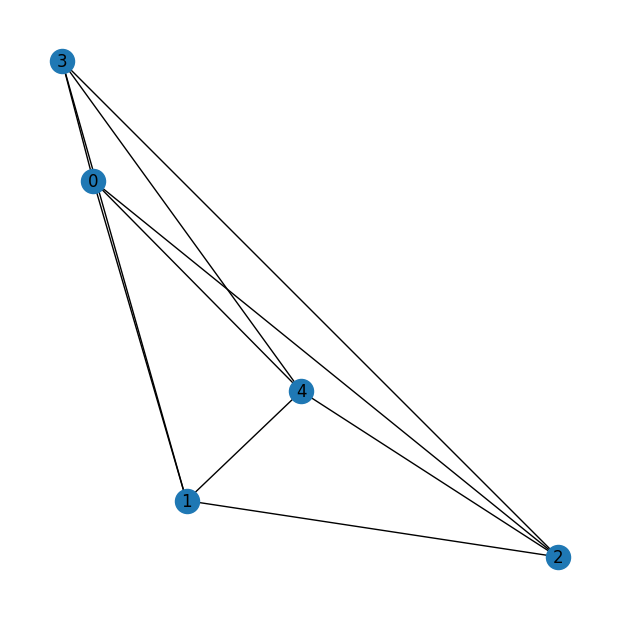

In [9]:
# the position helps to visualize the true graph. If pos is not passed to nx.draw, we lose information on 
# the position of the nodes (see the cell below this)
pos = {i: data.pos[i].tolist() for i in range(data.num_nodes)}

plt.figure(figsize=(6, 6))
nx.draw(G,pos,node_size=300,with_labels=True)
plt.show()

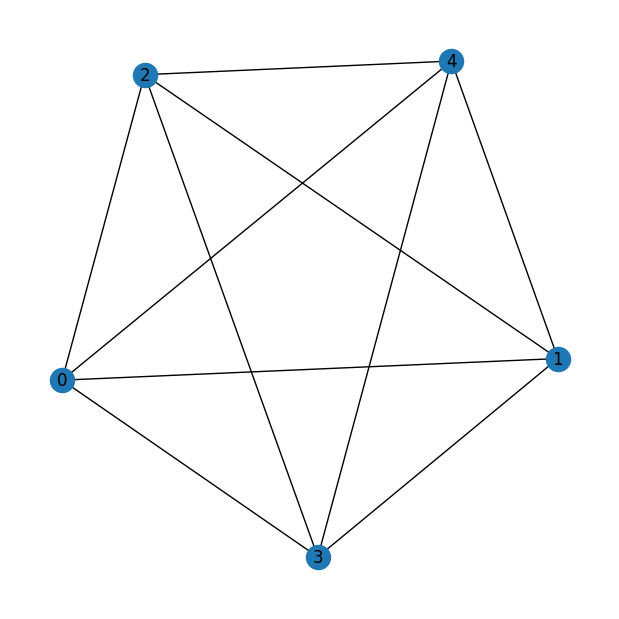

In [10]:
# this will give a neat graph 
plt.figure(figsize=(6, 6))
nx.draw(G,node_size=300,with_labels=True)
plt.show()

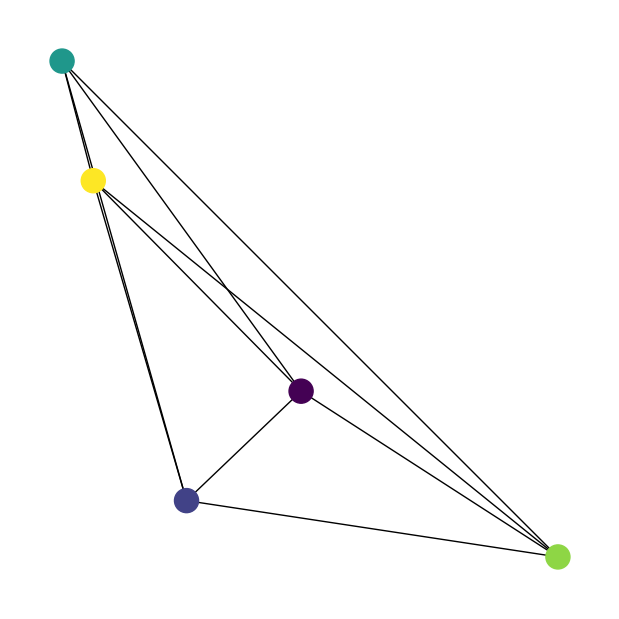

In [11]:
node_colors = data.x[:, 0].numpy()

plt.figure(figsize=(6, 6))
nx.draw(G,pos,node_color=node_colors,node_size=300,with_labels=False)
# plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'))
plt.show()


In [12]:
def create_random_graph(min_nodes=5, max_nodes=30, num_node_features=10, k=4):
    num_nodes = random.randint(min_nodes, max_nodes)

    x = torch.randn(num_nodes, num_node_features)

    pos = torch.randn(num_nodes, 2)

    edge_index = knn_graph(pos, k=k, loop=False)

    y = x.sum(dim=1).mean().unsqueeze(0)

    return Data(
        x=x,
        edge_index=edge_index,
        pos=pos,
        y=y
    )

In [13]:
def create_dataset(num_graphs=1000):
    dataset = []
    for _ in range(num_graphs):
        graph = create_random_graph()
        dataset.append(graph)
    return dataset

In [14]:
dataset = create_dataset(200)

In [15]:
print()
# print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset[0].x.shape[1]}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Number of graphs: 200
Number of features: 10

Data(x=[23, 10], edge_index=[2, 92], y=[1], pos=[23, 2])
Number of nodes: 23
Number of edges: 92
Average node degree: 4.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [16]:
def plot_geometric_data_as_graph(data):
    G = to_networkx(data, to_undirected=True, node_attrs=['x'], edge_attrs=None)
    pos = {i: data.pos[i].tolist() for i in range(data.num_nodes)}
    fig = plt.figure(figsize=(6, 6))
    nx.draw(G,pos,node_size=300,with_labels=False)
    plt.show()
    fig.clear()

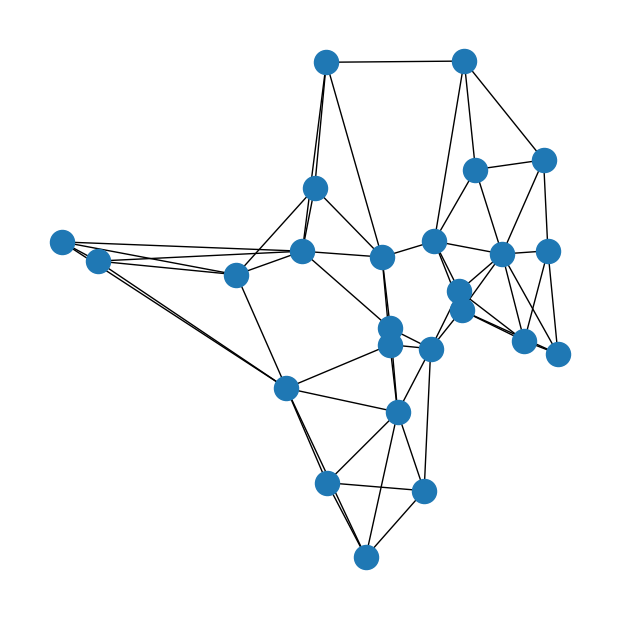

In [17]:
plot_geometric_data_as_graph(dataset[10])

### Splitting the dataset in to train and test dataset

In [18]:
train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 50


In [19]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[1269, 10], edge_index=[2, 5076], y=[64], pos=[1269, 2], batch=[1269], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[1119, 10], edge_index=[2, 4476], y=[64], pos=[1119, 2], batch=[1119], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(x=[414, 10], edge_index=[2, 1656], y=[22], pos=[414, 2], batch=[414], ptr=[23])



In [24]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCNRegressor(torch.nn.Module):
    def __init__(self, num_node_features,hidden_channels):
        super(GCNRegressor, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        
        return x

In [26]:
model = GCN(num_node_features=10,hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [33]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    mse_total = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out  # Use the class with highest probability.
        mse_value = F.mse_loss(pred, data.y)
        mse_total+=mse_value
#         print(pred)
#         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return mse_total / len(loader.dataset)  # Derive ratio of correct predictions.

In [35]:
for epoch in range(1, 200):
    train()
    train_mse = test(train_loader)
    test_mse = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
#     print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

C:\Users\akash\AppData\Local\Temp\ipykernel_1696\966456807.py:17: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_value = F.mse_loss(pred, data.y)
C:\Users\akash\AppData\Local\Temp\ipykernel_1696\966456807.py:17: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_value = F.mse_loss(pred, data.y)
C:\Users\akash\AppData\Local\Temp\ipykernel_1696\966456807.py:17: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_value = F.mse_loss(pred, data.y)


Epoch: 001, Train MSE: 0.0151, Test MSE: 0.0188
Epoch: 002, Train MSE: 0.0151, Test MSE: 0.0187
Epoch: 003, Train MSE: 0.0168, Test MSE: 0.0183
Epoch: 004, Train MSE: 0.0136, Test MSE: 0.0179
Epoch: 005, Train MSE: 0.0148, Test MSE: 0.0176
Epoch: 006, Train MSE: 0.0181, Test MSE: 0.0175
Epoch: 007, Train MSE: 0.0143, Test MSE: 0.0176
Epoch: 008, Train MSE: 0.0145, Test MSE: 0.0178
Epoch: 009, Train MSE: 0.0145, Test MSE: 0.0179
Epoch: 010, Train MSE: 0.0135, Test MSE: 0.0182
Epoch: 011, Train MSE: 0.0146, Test MSE: 0.0185
Epoch: 012, Train MSE: 0.0155, Test MSE: 0.0185
Epoch: 013, Train MSE: 0.0129, Test MSE: 0.0183
Epoch: 014, Train MSE: 0.0132, Test MSE: 0.0180
Epoch: 015, Train MSE: 0.0145, Test MSE: 0.0177
Epoch: 016, Train MSE: 0.0158, Test MSE: 0.0176
Epoch: 017, Train MSE: 0.0143, Test MSE: 0.0175
Epoch: 018, Train MSE: 0.0133, Test MSE: 0.0175
Epoch: 019, Train MSE: 0.0141, Test MSE: 0.0175
Epoch: 020, Train MSE: 0.0140, Test MSE: 0.0177
Epoch: 021, Train MSE: 0.0148, Test MSE:

Epoch: 172, Train MSE: 0.0163, Test MSE: 0.0180
Epoch: 173, Train MSE: 0.0149, Test MSE: 0.0181
Epoch: 174, Train MSE: 0.0140, Test MSE: 0.0182
Epoch: 175, Train MSE: 0.0139, Test MSE: 0.0182
Epoch: 176, Train MSE: 0.0132, Test MSE: 0.0181
Epoch: 177, Train MSE: 0.0147, Test MSE: 0.0180
Epoch: 178, Train MSE: 0.0140, Test MSE: 0.0180
Epoch: 179, Train MSE: 0.0136, Test MSE: 0.0179
Epoch: 180, Train MSE: 0.0143, Test MSE: 0.0179
Epoch: 181, Train MSE: 0.0133, Test MSE: 0.0179
Epoch: 182, Train MSE: 0.0137, Test MSE: 0.0179
Epoch: 183, Train MSE: 0.0146, Test MSE: 0.0179
Epoch: 184, Train MSE: 0.0147, Test MSE: 0.0179
Epoch: 185, Train MSE: 0.0136, Test MSE: 0.0179
Epoch: 186, Train MSE: 0.0137, Test MSE: 0.0180
Epoch: 187, Train MSE: 0.0139, Test MSE: 0.0180
Epoch: 188, Train MSE: 0.0132, Test MSE: 0.0180
Epoch: 189, Train MSE: 0.0155, Test MSE: 0.0180
Epoch: 190, Train MSE: 0.0138, Test MSE: 0.0180
Epoch: 191, Train MSE: 0.0148, Test MSE: 0.0180
Epoch: 192, Train MSE: 0.0155, Test MSE: